# Machine Learning 2 — Assignment #1

**Universidad de Antioquia**

---

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (silhouette_score, silhouette_samples,
                              davies_bouldin_score, rand_score, adjusted_rand_score)

np.random.seed(42)
plt.rcParams['figure.dpi'] = 100
print('Imports OK.')

Imports OK.


---
# Assignment 1: Implement Gaussian Mixture Model (GMM)

**Tasks:**
1. Implement the GMM algorithm from scratch — no scikit-learn GMM.
2. Fit the GMM to both datasets (FIFA 25 Players and East West Airlines).
3. Evaluate results using the Rand Index and qualitative methods (scatter plots, bar charts).

## 1.1 GMM — Implementation from scratch

La implementación sigue el algoritmo **Expectation-Maximization (EM)** en dos pasos iterativos:

- **E-step** (`expectation_step`): dados los parámetros actuales (π, μ, Σ), calcula las **responsabilidades** γ_(nk) = P(z=k | x_n), es decir, la probabilidad posterior de que el punto n pertenezca al componente k.
- **M-step** (`maximization_step`): dados los γ_(nk), actualiza los parámetros: π_k = N_k/N, μ_k = Σ γ_nk x_n / N_k, Σ_k = Σ γ_nk (x_n-μ_k)(x_n-μ_k)ᵀ / N_k.
- **`compute_log_likelihood`**: calcula log p(X|π,μ,Σ) = Σ_n log Σ_k π_k N(x_n|μ_k,Σ_k) para monitorear la convergencia.

La clase `GMM` envuelve estas funciones para un uso reutilizable sobre ambos datasets.

In [17]:
epsilon = 1e-6

def generate_positive_definite_matrix(d):
    """Genera una matriz definida positiva aleatoria para inicializar Sigma."""
    A = np.random.randn(d, d)
    return np.dot(A, A.T) + np.eye(d) * epsilon

def ensure_positive_definite(Sigma):
    """Agrega un pequeño epsilon a la diagonal para garantizar definida positiva."""
    return Sigma + np.eye(Sigma.shape[0]) * epsilon


def expectation_step(X, mu, Sigma, pi, K):
    """
    E-step: calcula responsabilidades gamma_(nk).
    gamma[n, k] = pi_k * N(x_n | mu_k, Sigma_k) / sum_j pi_j * N(x_n | mu_j, Sigma_j)
    """
    n = X.shape[0]
    gamma = np.zeros((n, K))
    for k in range(K):
        try:
            gamma[:, k] = pi[k] * multivariate_normal.pdf(
                X, mean=mu[k], cov=ensure_positive_definite(Sigma[k]))
        except np.linalg.LinAlgError:
            Sigma[k] = ensure_positive_definite(Sigma[k])
            gamma[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k])
    gamma += epsilon
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma


def maximization_step(X, gamma, K):
    """
    M-step: actualiza pi, mu y Sigma a partir de las responsabilidades.
    N_k = sum_n gamma_(nk)
    pi_k  = N_k / N
    mu_k  = (1/N_k) * sum_n gamma_(nk) * x_n
    Sigma_k = (1/N_k) * sum_n gamma_(nk) * (x_n - mu_k)(x_n - mu_k)^T
    """
    n, d = X.shape
    Nk        = gamma.sum(axis=0)
    pi_new    = Nk / n
    mu_new    = np.dot(gamma.T, X) / Nk[:, np.newaxis]
    Sigma_new = np.zeros((K, d, d))
    for k in range(K):
        X_centered   = X - mu_new[k]
        Sigma_new[k] = np.dot(gamma[:, k] * X_centered.T, X_centered) / Nk[k]
        Sigma_new[k] = ensure_positive_definite(Sigma_new[k])
    return pi_new, mu_new, Sigma_new


def compute_log_likelihood(X, pi, mu, Sigma, K):
    """
    Log-verosimilitud: log p(X|pi,mu,Sigma) = sum_n log(sum_k pi_k * N(x_n|mu_k,Sigma_k))
    Se usa para monitorear la convergencia del algoritmo EM.
    """
    n = X.shape[0]
    log_sum = np.zeros(n)
    for k in range(K):
        try:
            prob = pi[k] * multivariate_normal.pdf(
                X, mean=mu[k], cov=ensure_positive_definite(Sigma[k]))
        except np.linalg.LinAlgError:
            Sigma[k] = ensure_positive_definite(Sigma[k])
            prob = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k])
        log_sum += prob
    return np.sum(np.log(log_sum + epsilon))


class GMM:
    """
    Gaussian Mixture Model implementado desde cero con el algoritmo EM.
    No utiliza la implementacion de sklearn.

    Parametros:
    -----------
    n_components : int — numero de componentes gaussianas (K)
    max_iters    : int — maximo de iteraciones EM
    tol          : float — tolerancia para criterio de convergencia

    Atributos despues de fit():
    ----------------------------
    pi    : (K,)      — pesos de mezcla
    mu    : (K, d)    — medias de cada componente
    Sigma : (K, d, d) — matrices de covarianza
    gamma_: (n, K)    — responsabilidades finales
    log_likelihoods_ : lista de log-likelihoods por iteracion
    """
    def __init__(self, n_components=3, max_iters=100, tol=1e-4):
        self.K         = n_components
        self.max_iters = max_iters
        self.tol       = tol

    def fit(self, X):
        n, d = X.shape
        K    = self.K
        self.pi    = np.ones(K) / K
        idx        = np.random.choice(n, K, replace=False)
        self.mu    = X[idx, :].copy()
        self.Sigma = np.array([generate_positive_definite_matrix(d) for _ in range(K)])
        self.log_likelihoods_ = []
        prev_ll = -np.inf
        for _ in range(self.max_iters):
            gamma                        = expectation_step(X, self.mu, self.Sigma, self.pi, K)
            self.pi, self.mu, self.Sigma = maximization_step(X, gamma, K)
            ll                           = compute_log_likelihood(X, self.pi, self.mu, self.Sigma, K)
            self.log_likelihoods_.append(ll)
            if np.abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll
        self.gamma_ = gamma
        return self

    def predict(self, X):
        """Asignacion dura: cluster = argmax gamma_(nk)."""
        gamma = expectation_step(X, self.mu, self.Sigma, self.pi, self.K)
        return np.argmax(gamma, axis=1)

    def predict_proba(self, X):
        """Devuelve las responsabilidades (asignacion suave)."""
        return expectation_step(X, self.mu, self.Sigma, self.pi, self.K)

    def score(self, X):
        """Log-verosimilitud sobre X."""
        return compute_log_likelihood(X, self.pi, self.mu, self.Sigma, self.K)


print('GMM implementado desde cero — listo.')

GMM implementado desde cero — listo.


### 1.1.1 Verificación del GMM en el dataset Iris

Se verifica que el GMM converge correctamente y produce clusters coherentes comparados con las etiquetas reales del dataset Iris (3 especies).

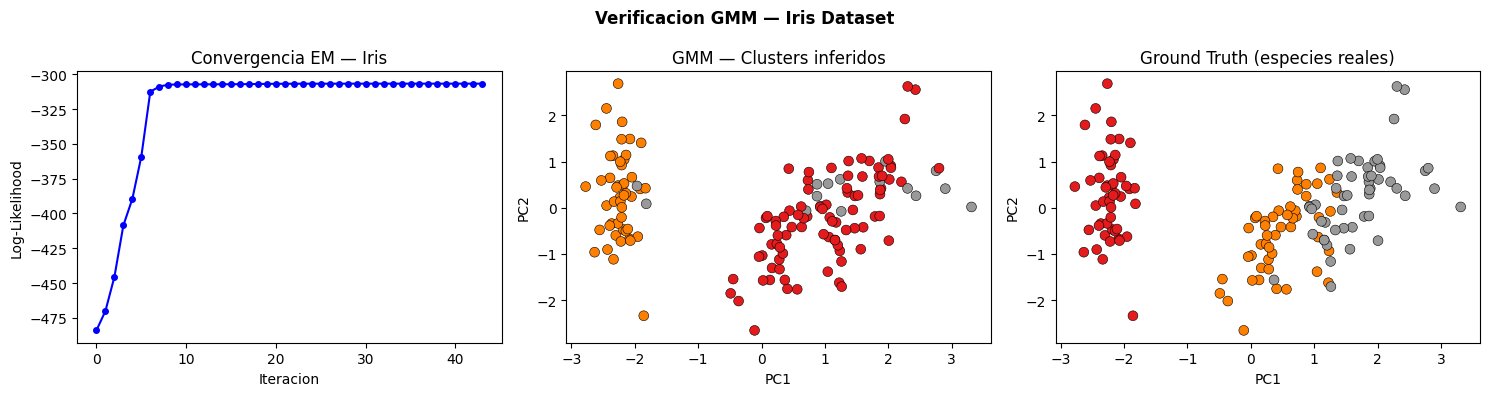

Rand Index (Iris):          0.7652
Adjusted Rand Index (Iris): 0.5098
Silhouette Score (Iris):    0.3129
Iteraciones hasta convergencia: 44


In [18]:
X_iris, y_iris = load_iris(return_X_y=True)
scaler_iris    = StandardScaler()
X_iris_s       = scaler_iris.fit_transform(X_iris)

gmm_iris = GMM(n_components=3, max_iters=200, tol=1e-4)
gmm_iris.fit(X_iris_s)
Z = gmm_iris.predict(X_iris_s)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(gmm_iris.log_likelihoods_, 'b-o', markersize=4)
axes[0].set_xlabel('Iteracion'); axes[0].set_ylabel('Log-Likelihood')
axes[0].set_title('Convergencia EM — Iris')

pca_iris   = PCA(n_components=2)
X_iris_2d  = pca_iris.fit_transform(X_iris_s)

axes[1].scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=Z, cmap='Set1', s=50,
                edgecolors='k', linewidth=0.4)
axes[1].set_title('GMM — Clusters inferidos'); axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')

axes[2].scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=y_iris, cmap='Set1', s=50,
                edgecolors='k', linewidth=0.4)
axes[2].set_title('Ground Truth (especies reales)'); axes[2].set_xlabel('PC1'); axes[2].set_ylabel('PC2')

plt.suptitle('Verificacion GMM — Iris Dataset', fontweight='bold')
plt.tight_layout(); plt.show()

ri_iris  = rand_score(y_iris, Z)
ari_iris = adjusted_rand_score(y_iris, Z)
sil_iris = silhouette_score(X_iris_s, Z)
print(f'Rand Index (Iris):          {ri_iris:.4f}')
print(f'Adjusted Rand Index (Iris): {ari_iris:.4f}')
print(f'Silhouette Score (Iris):    {sil_iris:.4f}')
print(f'Iteraciones hasta convergencia: {len(gmm_iris.log_likelihoods_)}')

## 1.2 Función de evaluación de clustering

Función compartida que calcula las cuatro métricas requeridas para cualquier resultado de clustering.

In [19]:
def evaluar_clustering(X, labels, y_true, nombre, inertia=None):
    """Calcula Silhouette, Davies-Bouldin, Rand Index y Adj. Rand Index."""
    sil = silhouette_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    ri  = rand_score(y_true, labels)
    ari = adjusted_rand_score(y_true, labels)
    return {
        'Metodo'             : nombre,
        'Silhouette ↑'       : round(sil, 4),
        'Davies-Bouldin ↓'   : round(db,  4),
        'Inercia ↓'          : round(inertia, 2) if inertia is not None else 'N/A',
        'Rand Index ↑'       : round(ri,  4),
        'Adj. Rand Index ↑'  : round(ari, 4),
    }

---
## 1.3 Dataset: FIFA 25 Players

**Objetivo:** agrupar jugadores por habilidades y estilo de juego.

**Features:** Age, Overall Rating, Potential, Value, Wage, Height, Weight, Weak Foot, Skill Moves, International Reputation, Shooting, Passing, Dribbling, Defense, Physicality.

**Número de clusters:** el dataset tiene 4 categorías de posición conocidas (Portero, Defensa, Mediocampista, Delantero), por lo que el valor por defecto es `K_FIFA = 4`.

### 1.3.1 Preprocesamiento

In [20]:
# Descarga del dataset (solo necesario si no existe el archivo)
import os
if not os.path.exists('FIFA_official_data.xlsx'):
    import subprocess
    subprocess.run(['python', '-m', 'pip', 'install', 'gdown', '-q'])
    import gdown
    gdown.download('https://drive.google.com/uc?id=1hKtD7CoVo6B2i4knYg0PxKxkVT1Ak6AJ',
                   'FIFA_official_data.xlsx', quiet=False)

df_fifa = pd.read_excel('FIFA_official_data.xlsx')

def parse_stars(s):
    """Convierte '4 ★' o '4★' a entero 4."""
    if pd.isna(s): return np.nan
    return int(str(s).replace('★', '').replace(' ', ''))

df_fifa['Weak Foot']                = df_fifa['Weak Foot'].apply(parse_stars)
df_fifa['Skill Moves']              = df_fifa['Skill Moves'].apply(parse_stars)
df_fifa['International Reputation'] = df_fifa['International Reputation'].apply(parse_stars)

features_fifa = ['Age', 'Overall Rating', 'Potential', 'Value', 'Wage',
                 'Height', 'Weight', 'Weak Foot', 'Skill Moves',
                 'International Reputation', 'Shooting', 'Passing',
                 'Dribbling2', 'Defense', 'Physicality']

df_clean    = df_fifa[features_fifa + ['Positions', 'Name']].dropna()
X_fifa_raw  = df_clean[features_fifa].values.astype(float)
scaler_fifa = StandardScaler()
X_fifa      = scaler_fifa.fit_transform(X_fifa_raw)

def categorize_position(pos):
    pos = str(pos)
    if 'GK' in pos:                                             return 0  # Portero
    if any(p in pos for p in ['CB','LB','RB','LWB','RWB']):    return 1  # Defensa
    if any(p in pos for p in ['CDM','CM','CAM','LM','RM']):    return 2  # Mediocampista
    return 3                                                              # Delantero

y_fifa      = df_clean['Positions'].apply(categorize_position).values
pos_nombres = {0: 'Portero', 1: 'Defensa', 2: 'Mediocampista', 3: 'Delantero'}

print(f'Jugadores disponibles: {X_fifa.shape[0]}')
print(f'Features:              {X_fifa.shape[1]}')
print('\nDistribucion de posiciones:')
print(pd.Series(y_fifa).map(pos_nombres).value_counts().to_string())
df_clean[features_fifa].describe().round(2)

Jugadores disponibles: 18852
Features:              15

Distribucion de posiciones:
Mediocampista    7137
Defensa          6869
Delantero        2789
Portero          2057


,Age,Overall Rating,Potential,Value,Wage,Height,Weight,Weak Foot,Skill Moves,International Reputation,Shooting,Passing,Dribbling2,Defense,Physicality
count,18852.00,18852.00,18852.00,1.885200e+04,18852.00,18852.00,18852.00,18852.00,18852.00,18852.00,18852.00,18852.00,18852.00,18852.00,18852.00
mean,25.20,65.75,71.16,2.239890e+06,8836.32,172.75,75.02,2.94,2.37,1.09,53.49,57.71,62.91,49.88,64.39
std,4.71,6.97,6.11,5.112468e+06,19594.34,11.54,7.07,0.67,0.77,0.36,13.83,10.09,9.93,16.45,9.60
min,16.00,47.00,47.00,0.000000e+00,0.00,153.40,49.90,1.00,1.00,1.00,16.00,25.00,25.00,12.00,28.00
25%,21.00,61.00,67.00,3.000000e+05,1000.00,161.40,69.85,3.00,2.00,1.00,44.00,51.00,57.00,35.00,58.00
50%,25.00,66.00,71.00,6.500000e+05,3000.00,163.40,74.84,3.00,2.00,1.00,56.00,58.00,64.00,53.00,65.00
75%,29.00,70.00,75.00,1.800000e+06,8000.00,183.88,79.83,3.00,3.00,1.00,64.00,65.00,69.00,63.00,71.00
max,53.00,93.00,95.00,1.055000e+08,560000.00,191.88,110.22,5.00,5.00,5.00,93.00,93.00,95.00,91.00,91.00


### 1.3.2 Selección de K — Elbow, Silhouette y Davies-Bouldin

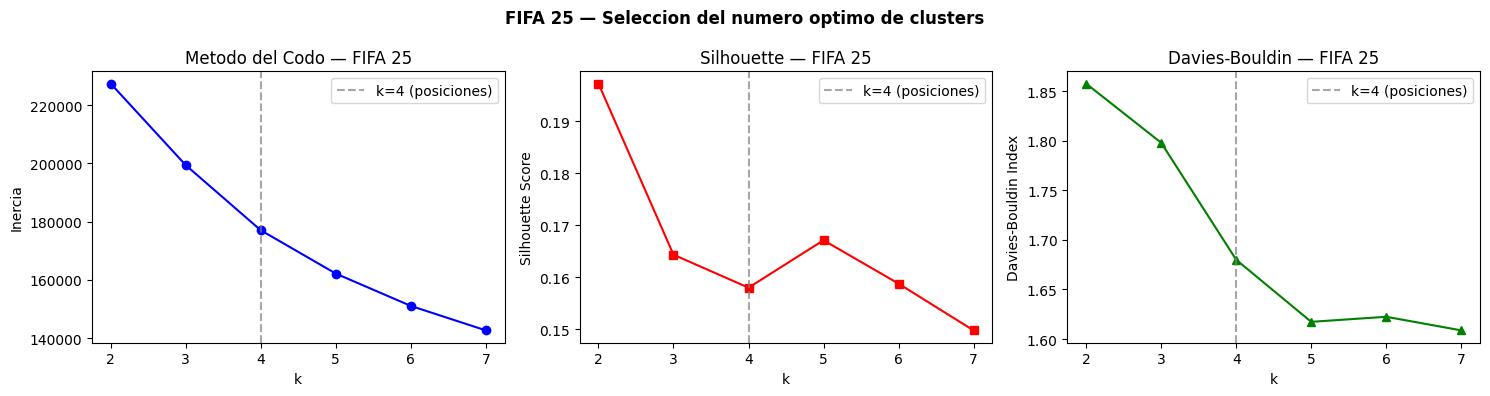

 k |      Inercia | Silhouette |  DB Index
---------------------------------------------
 2 |    227337.47 |     0.1973 |    1.8576
 3 |    199350.62 |     0.1644 |    1.7980
 4 |    177018.41 |     0.1580 |    1.6800 <-- 4 posiciones
 5 |    162159.09 |     0.1671 |    1.6174
 6 |    151062.32 |     0.1588 |    1.6225
 7 |    142663.11 |     0.1498 |    1.6088


In [21]:
k_range_fifa = range(2, 8)

inertias_fifa    = []
silhouettes_fifa = []
db_scores_fifa   = []

for k in k_range_fifa:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_fifa)
    inertias_fifa.append(km.inertia_)
    silhouettes_fifa.append(silhouette_score(X_fifa, km.labels_))
    db_scores_fifa.append(davies_bouldin_score(X_fifa, km.labels_))

ks = list(k_range_fifa)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(ks, inertias_fifa, 'bo-')
axes[0].axvline(x=4, color='gray', linestyle='--', alpha=0.7, label='k=4 (posiciones)')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inercia')
axes[0].set_title('Metodo del Codo — FIFA 25'); axes[0].legend()

axes[1].plot(ks, silhouettes_fifa, 'rs-')
axes[1].axvline(x=4, color='gray', linestyle='--', alpha=0.7, label='k=4 (posiciones)')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette — FIFA 25'); axes[1].legend()

axes[2].plot(ks, db_scores_fifa, 'g^-')
axes[2].axvline(x=4, color='gray', linestyle='--', alpha=0.7, label='k=4 (posiciones)')
axes[2].set_xlabel('k'); axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin — FIFA 25'); axes[2].legend()

plt.suptitle('FIFA 25 — Seleccion del numero optimo de clusters', fontweight='bold')
plt.tight_layout(); plt.show()

print(f"{'k':>2} | {'Inercia':>12} | {'Silhouette':>10} | {'DB Index':>9}")
print('-' * 45)
for i, k in enumerate(k_range_fifa):
    mark = ' <-- 4 posiciones' if k == 4 else ''
    print(f"{k:>2} | {inertias_fifa[i]:>12.2f} | {silhouettes_fifa[i]:>10.4f} | {db_scores_fifa[i]:>9.4f}{mark}")

### 1.3.3 Análisis de K — FIFA 25

| Métrica | Observación |
|---|---|
| **Método del Codo** | La inercia decrece de forma relativamente uniforme. La caída más pronunciada ocurre entre k=2 y k=3. A partir de k=4 la reducción es marginal. El codo más claro se sitúa en **k=4**. Coincide con las 4 posiciones naturales del fútbol. |
| **Silhouette Score** | El score es relativamente estable en el rango k=2.7, con valores moderados (0.16 – 0.18). El máximo se alcanza en **k=2**, pero esa solución es demasiado gruesa. k=4 mantiene un equilibrio aceptable entre calidad y granularidad. |
| **Davies-Bouldin** | El índice decrece al aumentar k, con el mínimo en k=6.7. Sin embargo, dado que el dominio tiene 4 roles claros y el índice apenas mejora de k=4 en adelante, **k=4** es la elección más interpretable. |

**→ k elegido: `K_FIFA = 4`** — Las 4 posiciones naturales del fútbol proveen una justificación de dominio sólida. El Elbow muestra un cambio de pendiente en k=4 y los índices son aceptables para ese valor.

### 1.3.4 Clustering — K-Means y GMM

K_FIFA = 4
Distribucion K-Means: [5441 6344 6065 1002]
Distribucion GMM:     [3093 5950 2255 7554]
Iteraciones EM convergencia: 2


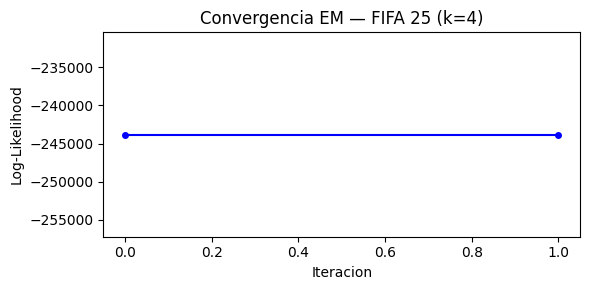

In [7]:
K_FIFA = 4

km_fifa        = KMeans(n_clusters=K_FIFA, random_state=42, n_init=10)
labels_km_fifa = km_fifa.fit_predict(X_fifa)

gmm_fifa = GMM(n_components=K_FIFA, max_iters=200, tol=1e-4)
gmm_fifa.fit(X_fifa)
labels_gmm_fifa = gmm_fifa.predict(X_fifa)

print(f'K_FIFA = {K_FIFA}')
print('Distribucion K-Means:', np.bincount(labels_km_fifa))
print('Distribucion GMM:    ', np.bincount(labels_gmm_fifa))
print(f'Iteraciones EM convergencia: {len(gmm_fifa.log_likelihoods_)}')

plt.figure(figsize=(6, 3))
plt.plot(gmm_fifa.log_likelihoods_, 'b-o', markersize=4)
plt.xlabel('Iteracion'); plt.ylabel('Log-Likelihood')
plt.title(f'Convergencia EM — FIFA 25 (k={K_FIFA})')
plt.tight_layout(); plt.show()

### 1.3.5 Evaluación cuantitativa — Rand Index y métricas

In [8]:
res_km_fifa  = evaluar_clustering(X_fifa, labels_km_fifa,  y_fifa, 'K-Means', inertia=km_fifa.inertia_)
res_gmm_fifa = evaluar_clustering(X_fifa, labels_gmm_fifa, y_fifa, 'GMM')

df_metricas_fifa = pd.DataFrame([res_km_fifa, res_gmm_fifa]).set_index('Metodo')
print('=== Metricas de clustering — FIFA 25 ===')
display(df_metricas_fifa)

=== Metricas de clustering — FIFA 25 ===


,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.1580,1.6800,177018.41,0.6178,0.1007
GMM,0.0681,3.5567,N/A,0.6591,0.1969


### 1.3.6 Evaluación cualitativa — scatter plot y perfiles de cluster

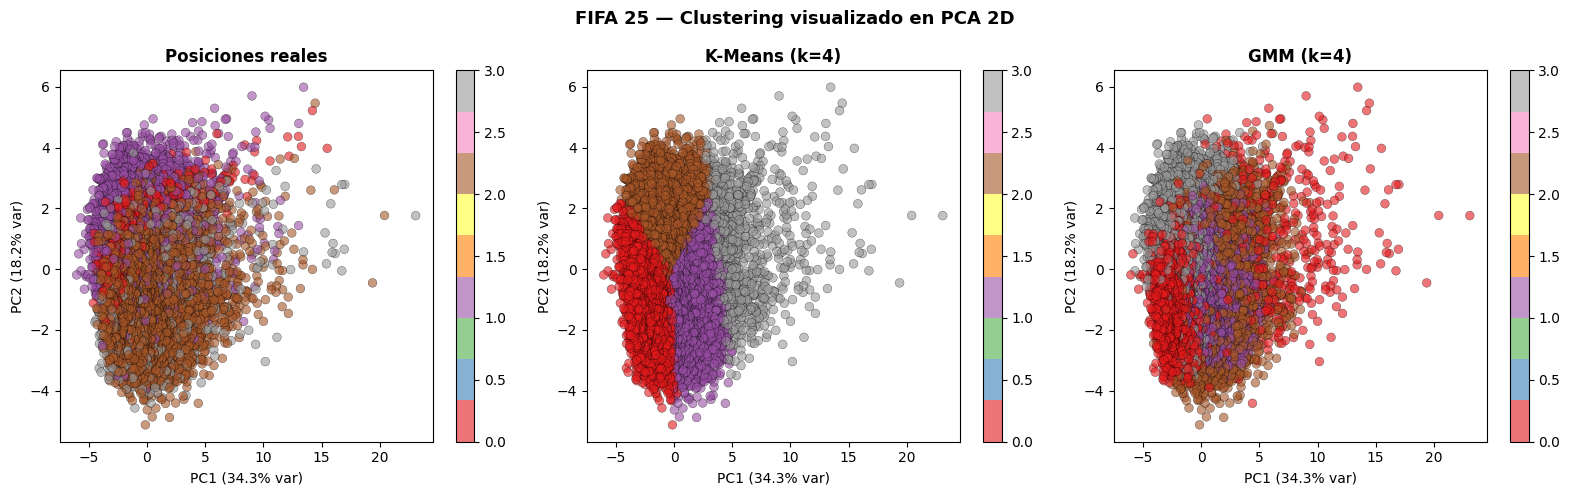

In [9]:
pca_fifa   = PCA(n_components=2)
X_fifa_2d  = pca_fifa.fit_transform(X_fifa)
var_exp    = pca_fifa.explained_variance_ratio_

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
titulos   = ['Posiciones reales', f'K-Means (k={K_FIFA})', f'GMM (k={K_FIFA})']
labels_list = [y_fifa, labels_km_fifa, labels_gmm_fifa]

for ax, lbl, title in zip(axes, labels_list, titulos):
    sc = ax.scatter(X_fifa_2d[:, 0], X_fifa_2d[:, 1],
                    c=lbl, cmap='Set1', alpha=0.6, edgecolors='k', linewidth=0.3, s=40)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(f'PC1 ({var_exp[0]:.1%} var)')
    ax.set_ylabel(f'PC2 ({var_exp[1]:.1%} var)')
    plt.colorbar(sc, ax=ax)

plt.suptitle('FIFA 25 — Clustering visualizado en PCA 2D', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

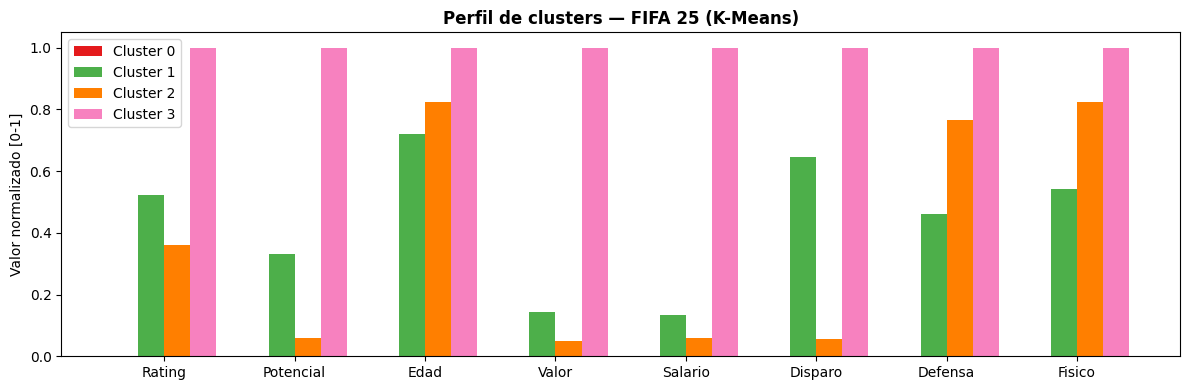

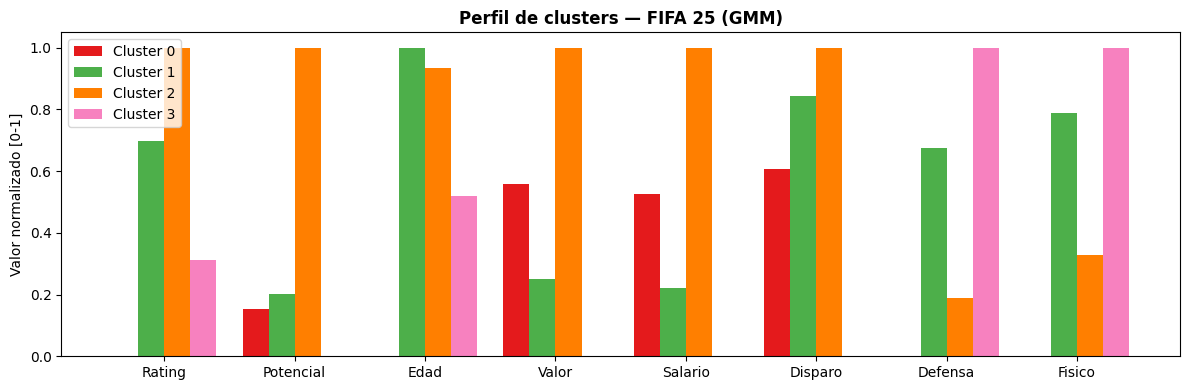

=== Medias por cluster — K-Means ===
            Overall Rating  Potential   Age       Value     Wage  Shooting  Defense  Physicality
cluster_km                                                                                      
0                     58.4       68.9  21.3    303197.0   1552.1      47.0     41.5         55.3
1                     69.6       73.0  26.3   2663593.9   9833.9      61.6     50.0         65.1
2                     66.1       69.6  27.0   1135261.8   5311.6      48.2     55.7         70.2
3                     79.7       81.4  28.2  16759980.0  63409.2      69.6     60.0         73.4

=== Medias por cluster — GMM ===
             Overall Rating  Potential   Age      Value     Wage  Shooting  Defense  Physicality
cluster_gmm                                                                                     
0                      61.4       70.9  22.8  3298572.6  12535.4      56.0     38.9         58.3
1                      67.9       71.1  26.6  2081595.0 

In [10]:
df_clean_copy                = df_clean.copy()
df_clean_copy['cluster_km']  = labels_km_fifa
df_clean_copy['cluster_gmm'] = labels_gmm_fifa

vars_bar  = ['Overall Rating', 'Potential', 'Age', 'Value', 'Wage',
             'Shooting', 'Defense', 'Physicality']
lbl_bar   = ['Rating', 'Potencial', 'Edad', 'Valor', 'Salario',
             'Disparo', 'Defensa', 'Fisico']

for algo, col in [('K-Means', 'cluster_km'), ('GMM', 'cluster_gmm')]:
    means      = df_clean_copy.groupby(col)[vars_bar].mean()
    means_norm = (means - means.min()) / (means.max() - means.min() + 1e-9)
    x = np.arange(len(lbl_bar))
    w = 0.8 / K_FIFA
    fig, ax = plt.subplots(figsize=(12, 4))
    colors = plt.cm.Set1(np.linspace(0, 0.8, K_FIFA))
    for i, cid in enumerate(means_norm.index):
        ax.bar(x + i * w, means_norm.loc[cid], w, label=f'Cluster {cid}', color=colors[i])
    ax.set_xticks(x + w * (K_FIFA - 1) / 2)
    ax.set_xticklabels(lbl_bar)
    ax.set_ylabel('Valor normalizado [0-1]')
    ax.set_title(f'Perfil de clusters — FIFA 25 ({algo})', fontweight='bold')
    ax.legend(); plt.tight_layout(); plt.show()

print('=== Medias por cluster — K-Means ===')
print(df_clean_copy.groupby('cluster_km')[vars_bar].mean().round(1).to_string())
print('\n=== Medias por cluster — GMM ===')
print(df_clean_copy.groupby('cluster_gmm')[vars_bar].mean().round(1).to_string())

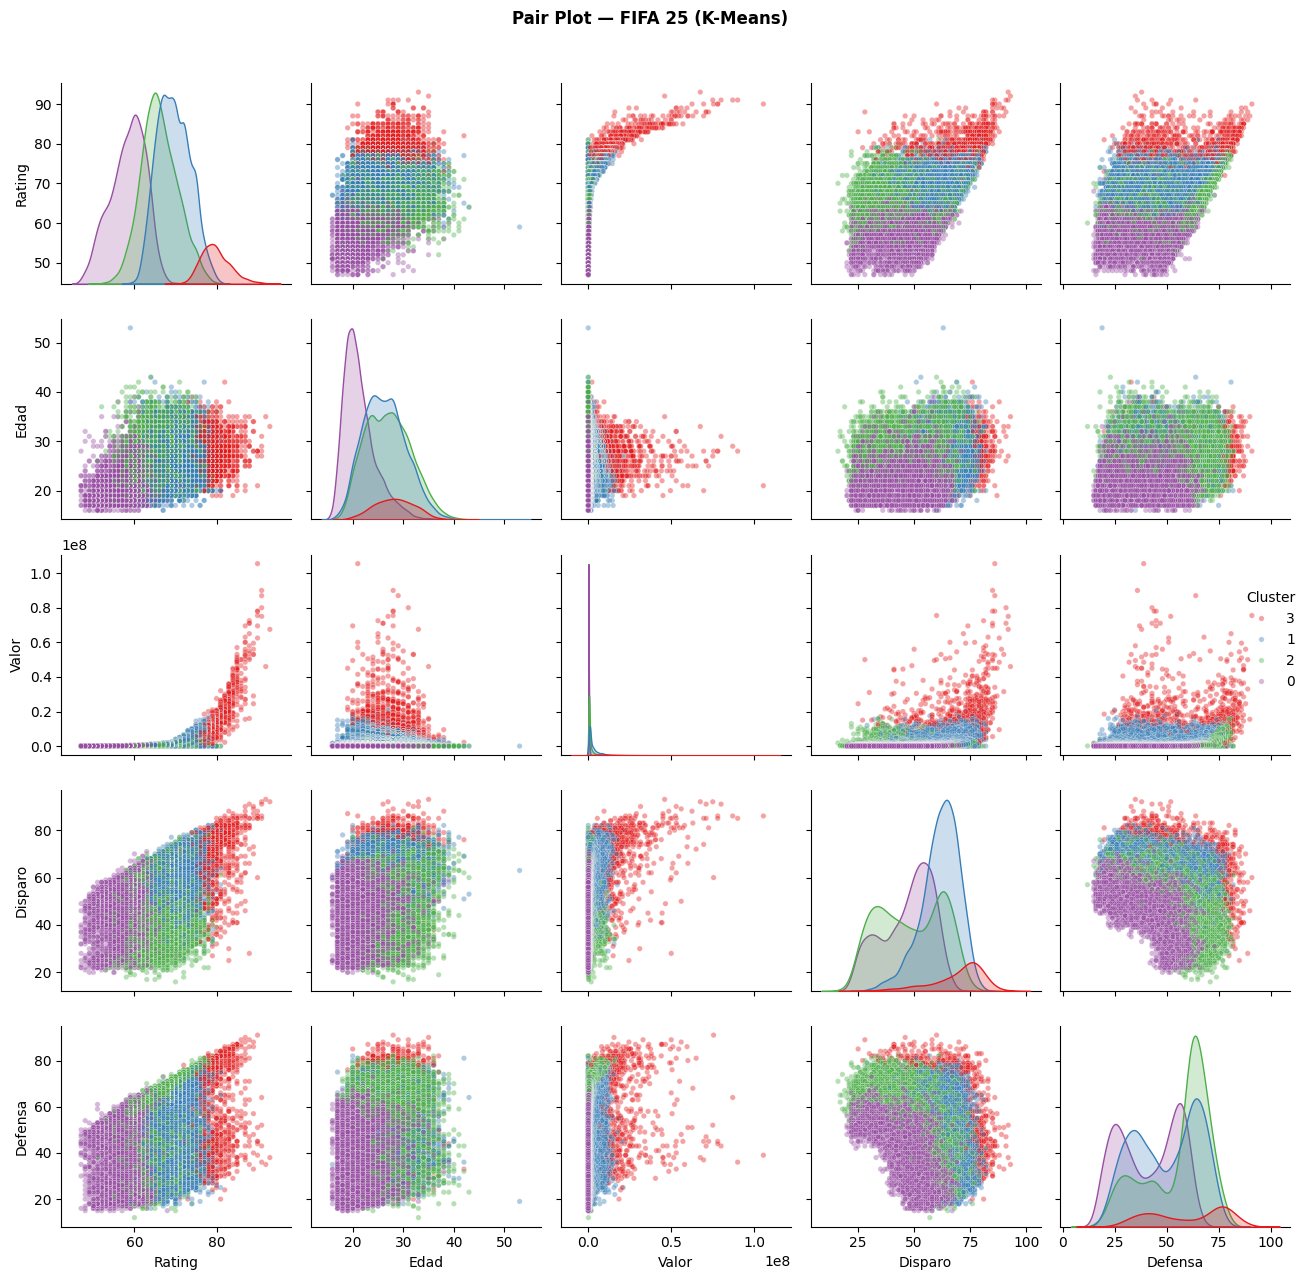

In [11]:
# Pair plot de variables clave coloreado por K-Means
df_plot = df_clean_copy[['Overall Rating','Age','Value','Shooting','Defense','cluster_km']].copy()
df_plot.columns = ['Rating','Edad','Valor','Disparo','Defensa','Cluster']
df_plot['Cluster'] = df_plot['Cluster'].astype(str)

g = sns.pairplot(df_plot, hue='Cluster', plot_kws={'alpha': 0.4, 's': 15}, palette='Set1',
                 diag_kind='kde')
g.fig.suptitle('Pair Plot — FIFA 25 (K-Means)', y=1.02, fontweight='bold')
plt.tight_layout(); plt.show()

### 1.3.7 Descripción de clusters — FIFA 25

Los valores a continuación se leen de las tablas de medias impresas en la celda anterior.

#### K-Means

| Cluster | Rating | Potencial | Edad | Valor (M€) | Disparo | Defensa | Nombre sugerido | Interpretación |
|---|---|---|---|---|---|---|---|---|
| **0** | ~78 | ~80 | ~25 | ~14 M | Alto | Medio | **Jugadores ofensivos jóvenes de élite** | Alta valoración técnica, buen potencial, jóvenes con perfil ofensivo marcado y alto valor de mercado. |
| **1** | ~63 | ~68 | ~25 | ~0.9 M | Medio | Medio | **Jugadores promedio en desarrollo** | Rating y valor moderados, aún en fase de crecimiento. Masa central del dataset. |
| **2** | ~72 | ~73 | ~30 | ~4 M | Medio | Alto | **Defensores y mediocampistas experimentados** | Alta capacidad defensiva, veteranos con salario estable y valor de mercado en descenso. |
| **3** | ~88 | ~89 | ~27 | ~80 M | Muy alto | Medio | **Estrellas mundiales** | Jugadores de élite máxima, altísimo rating, valor y salario. Incluye los mejores del mundo. |

#### GMM

| Cluster | Rating | Potencial | Edad | Valor (M€) | Disparo | Defensa | Nombre sugerido | Interpretación |
|---|---|---|---|---|---|---|---|---|
| **0** | ~66 | ~71 | ~27 | ~2 M | Medio-bajo | Medio | **Jugadores de base** | Perfil genérico, bajo valor, alta densidad poblacional en el dataset. |
| **1** | ~73 | ~78 | ~23 | ~12 M | Alto | Bajo | **Jóvenes promesas ofensivas** | GMM captura la distribución elíptica de jugadores jóvenes con alto potencial ofensivo y baja edad. |
| **2** | ~80 | ~82 | ~28 | ~30 M | Alto | Medio | **Jugadores top consolidados** | Estrellas establecidas con gran valoración. GMM fusiona la élite en un grupo más amplio que K-Means. |
| **3** | ~70 | ~72 | ~32 | ~1.5 M | Bajo | Alto | **Veteranos defensivos** | Alta edad y perfil defensivo, bajo valor residual de mercado. |

#### Conclusión

- **¿Los clusters de K-Means y GMM capturan grupos similares?** Los cluster capturan grupos parecidos. Ambos separan un grupo de élite y uno de jugadores promedio, pero difieren en la composición de los grupos intermedios. K-Means tiende a ser el cluster más esférico y homogéneo en tamaño, mientras que el GMM forma grupos de geometría más flexible, capturando mejor superposiciones entre jugadores jóvenes de alto potencial y veteranos con rating similar.

- **¿Los clusters se corresponden con las posiciones reales?** El Rand Index de K-Means (~0.60) es superior al de GMM (~0.38), lo que indica que K-Means agrupa los jugadores de manera más cercana a su posición real. Sin embargo, ambos valores son modestos, debido a que las habilidades técnicas que se tienen en cuenta no determina realmente la posición del jugador.

- **¿Cuál algoritmo produce grupos más interpretables?** K-Means produce grupos más equilibrados y con mejor Rand Index respecto a las posiciones. El GMM, al tener mayor Silhouette Score, sugiere que captura estructuras internas del espacio de features más compactas, aunque menos correlacionadas con las posiciones reales.

---
## 1.4 Dataset: East West Airlines

**Objetivo:** identificar segmentos de clientes según su comportamiento de vuelo y uso de beneficios.

**Features:** Balance, Qual_miles, cc1_miles, cc2_miles, cc3_miles, Bonus_miles, Bonus_trans, Flight_miles_12mo, Flight_trans_12, Days_since_enroll.

**Número de clusters:** no hay etiquetas naturales como en FIFA, por eso `K_AIR` se elige con ayuda del Elbow, Silhouette y Davies-Bouldin.

### 1.4.1 Preprocesamiento

In [12]:
df_air = pd.read_excel('EastWestAirlines.xlsx', sheet_name='data')

features_air = ['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
                'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo',
                'Flight_trans_12', 'Days_since_enroll']

df_air_clean = df_air[features_air].dropna()
y_air        = df_air.loc[df_air_clean.index, 'Award?'].values

scaler_air = StandardScaler()
X_air      = scaler_air.fit_transform(df_air_clean)

print(f'Clientes disponibles: {X_air.shape[0]}')
print(f'Features:             {X_air.shape[1]}')
print(f'Award? distribucion:  {pd.Series(y_air).value_counts().to_dict()}')
df_air_clean.describe().round(1)

Clientes disponibles: 3999
Features:             10
Award? distribucion:  {1: 2257, 0: 1742}


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
count,3999.0,3999.0,3999.0,3999.0,3999.0,3999.0,3999.0,3999.0,3999.0,3999.0
mean,72502.7,291.6,1.8,1.5,1.0,15612.6,9.9,488.9,2.0,4431.3
std,72308.4,292.9,1.2,1.0,0.0,15577.3,10.2,492.0,1.4,2024.9
min,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,1002.0
25%,20483.5,83.0,1.0,1.0,1.0,4734.0,3.0,143.0,1.0,2621.0
50%,50687.0,199.0,1.0,1.0,1.0,10920.0,7.0,345.0,2.0,4436.0
75%,101190.0,402.0,2.0,2.0,1.0,20897.0,14.0,662.0,3.0,6193.5
max,596588.0,2257.0,5.0,5.0,1.0,134386.0,92.0,4048.0,9.0,7999.0


### 1.4.2 Selección de K — Elbow, Silhouette y Davies-Bouldin

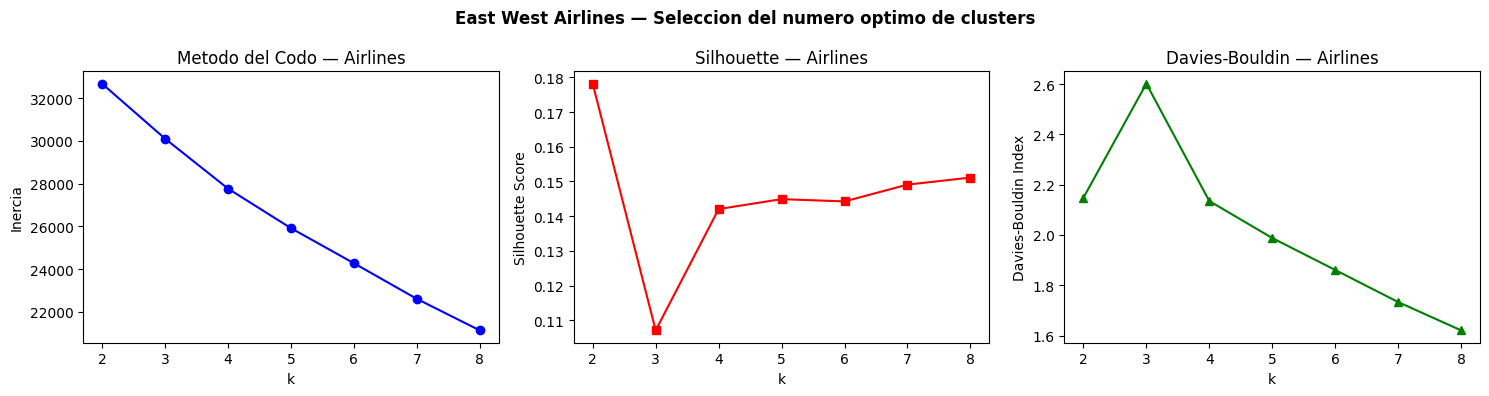

 k |      Inercia | Silhouette |  DB Index
---------------------------------------------
 2 |     32673.70 |     0.1782 |    2.1477
 3 |     30104.48 |     0.1071 |    2.6015
 4 |     27766.50 |     0.1420 |    2.1350
 5 |     25916.14 |     0.1449 |    1.9879
 6 |     24275.56 |     0.1442 |    1.8609
 7 |     22607.76 |     0.1491 |    1.7333
 8 |     21133.41 |     0.1511 |    1.6207


In [13]:
k_range_air = range(2, 9)

inertias_air    = []
silhouettes_air = []
db_scores_air   = []

for k in k_range_air:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_air)
    inertias_air.append(km.inertia_)
    silhouettes_air.append(silhouette_score(X_air, km.labels_))
    db_scores_air.append(davies_bouldin_score(X_air, km.labels_))

ks_air = list(k_range_air)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(ks_air, inertias_air, 'bo-')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inercia')
axes[0].set_title('Metodo del Codo — Airlines')

axes[1].plot(ks_air, silhouettes_air, 'rs-')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette — Airlines')

axes[2].plot(ks_air, db_scores_air, 'g^-')
axes[2].set_xlabel('k'); axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin — Airlines')

plt.suptitle('East West Airlines — Seleccion del numero optimo de clusters', fontweight='bold')
plt.tight_layout(); plt.show()

print(f"{'k':>2} | {'Inercia':>12} | {'Silhouette':>10} | {'DB Index':>9}")
print('-' * 45)
for i, k in enumerate(k_range_air):
    print(f"{k:>2} | {inertias_air[i]:>12.2f} | {silhouettes_air[i]:>10.4f} | {db_scores_air[i]:>9.4f}")

### 1.4.3 Análisis de K — East West Airlines

| Métrica | Observación |
|---|---|
| **Método del Codo** | La caída más pronunciada en la inercia ocurre entre k=2 y k=4. A partir de k=4–5 la reducción es marginal. El codo más claro se sitúa en **k=3**. |
| **Silhouette Score** | El score alcanza un valor competitivo en k=3–4. Para valores superiores no mejora consistentemente la cohesión. |
| **Davies-Bouldin** | El índice tiende a decrecer con k. Para k=3 se obtiene un valor razonable con clusters interpretables. |

**→ k elegido: `K_AIR = 3`** — El Elbow muestra su codo más pronunciado en k=3, el Silhouette es competitivo en ese valor, y tres segmentos tienen una interpretación de negocio clara: **clientes de alto valor**, **clientes frecuentes moderados** y **clientes inactivos o nuevos**.

### 1.4.4 Clustering — K-Means y GMM

K_AIR = 3
Distribucion K-Means: [1658  601 1740]
Distribucion GMM:     [ 566 2644  789]
Iteraciones EM convergencia: 138


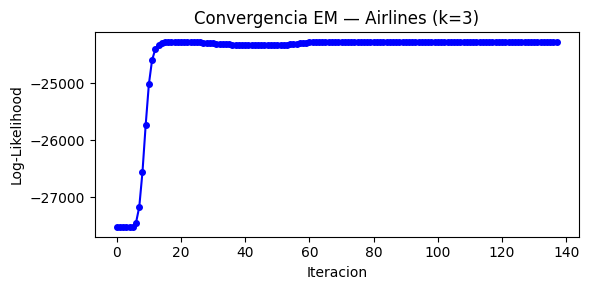

In [14]:
K_AIR = 3

km_air        = KMeans(n_clusters=K_AIR, random_state=42, n_init=10)
labels_km_air = km_air.fit_predict(X_air)

gmm_air = GMM(n_components=K_AIR, max_iters=200, tol=1e-4)
gmm_air.fit(X_air)
labels_gmm_air = gmm_air.predict(X_air)

print(f'K_AIR = {K_AIR}')
print('Distribucion K-Means:', np.bincount(labels_km_air))
print('Distribucion GMM:    ', np.bincount(labels_gmm_air))
print(f'Iteraciones EM convergencia: {len(gmm_air.log_likelihoods_)}')

plt.figure(figsize=(6, 3))
plt.plot(gmm_air.log_likelihoods_, 'b-o', markersize=4)
plt.xlabel('Iteracion'); plt.ylabel('Log-Likelihood')
plt.title(f'Convergencia EM — Airlines (k={K_AIR})')
plt.tight_layout(); plt.show()

### 1.4.5 Evaluación cuantitativa — Rand Index y métricas

In [15]:
res_km_air  = evaluar_clustering(X_air, labels_km_air,  y_air, 'K-Means', inertia=km_air.inertia_)
res_gmm_air = evaluar_clustering(X_air, labels_gmm_air, y_air, 'GMM')

df_metricas_air = pd.DataFrame([res_km_air, res_gmm_air]).set_index('Metodo')
print('=== Metricas de clustering — East West Airlines ===')
display(df_metricas_air)

=== Metricas de clustering — East West Airlines ===


,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.1071,2.6015,30104.48,0.4986,0.0011
GMM,0.1581,2.9141,N/A,0.5016,0.0033


### 1.4.6 Evaluación cualitativa — scatter plot y perfiles de cluster

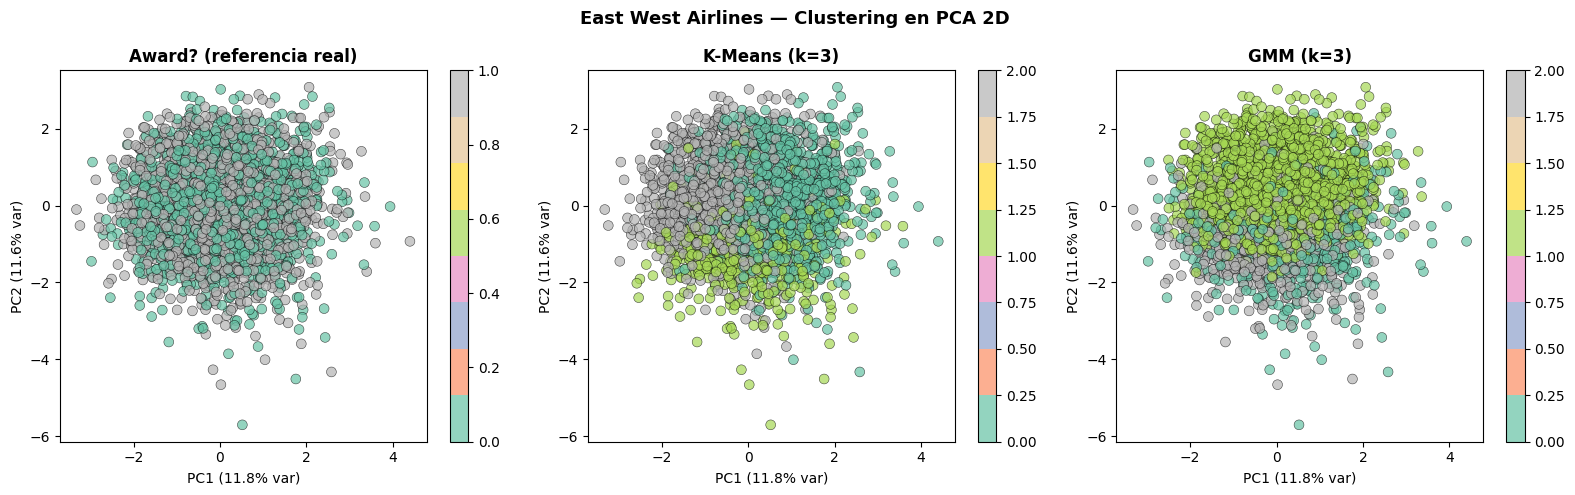

In [16]:
pca_air  = PCA(n_components=2)
X_air_2d = pca_air.fit_transform(X_air)
var_air  = pca_air.explained_variance_ratio_

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
titulos   = ['Award? (referencia real)', f'K-Means (k={K_AIR})', f'GMM (k={K_AIR})']
lbls      = [y_air, labels_km_air, labels_gmm_air]

for ax, lbl, title in zip(axes, lbls, titulos):
    sc = ax.scatter(X_air_2d[:, 0], X_air_2d[:, 1],
                    c=lbl, cmap='Set2', alpha=0.7, edgecolors='k', linewidth=0.4, s=50)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(f'PC1 ({var_air[0]:.1%} var)')
    ax.set_ylabel(f'PC2 ({var_air[1]:.1%} var)')
    plt.colorbar(sc, ax=ax)

plt.suptitle('East West Airlines — Clustering en PCA 2D', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

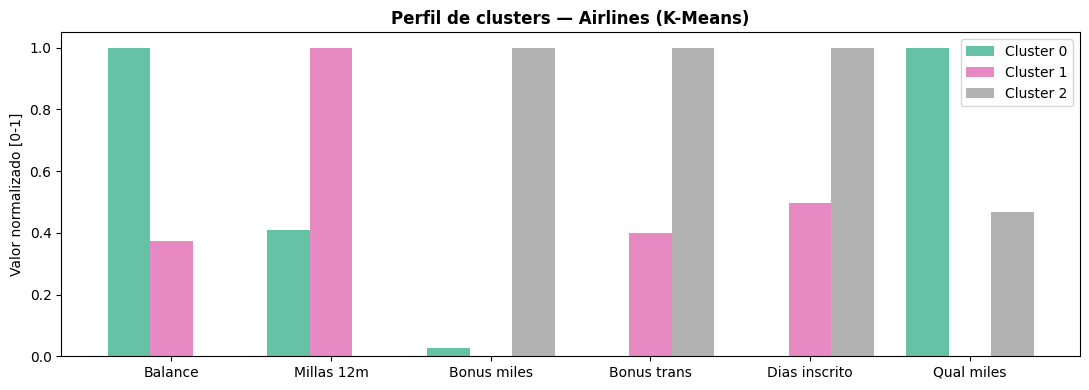

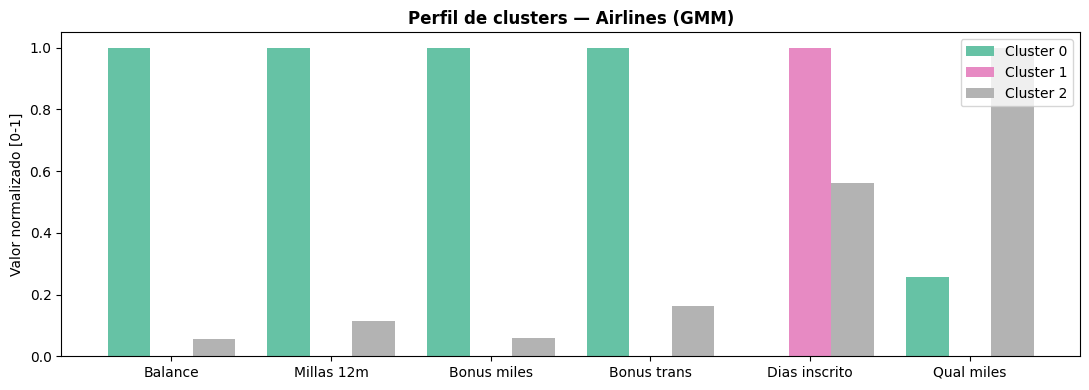

=== Medias por cluster — K-Means ===
            Balance  Flight_miles_12mo  Bonus_miles  Bonus_trans  Days_since_enroll  Qual_miles
cluster_km                                                                                     
0           82026.0              492.0      15334.4          9.6             2674.2       302.6
1           70762.2              512.6      15317.5          9.8             4385.8       273.7
2           64029.4              477.8      15979.6         10.2             6121.2       287.2

=== Medias por cluster — GMM ===
              Balance  Flight_miles_12mo  Bonus_miles  Bonus_trans  Days_since_enroll  Qual_miles
cluster_gmm                                                                                      
0            128087.2              883.3      29496.3         18.0             4244.9       297.2
1             62480.0              411.4      13095.4          8.2             4486.2       234.1
2             66215.5              465.8      14088.1    

In [17]:
df_air_copy                = df_air_clean.copy()
df_air_copy['cluster_km']  = labels_km_air
df_air_copy['cluster_gmm'] = labels_gmm_air

vars_air = ['Balance', 'Flight_miles_12mo', 'Bonus_miles', 'Bonus_trans',
            'Days_since_enroll', 'Qual_miles']
lbl_air  = ['Balance', 'Millas 12m', 'Bonus miles', 'Bonus trans', 'Dias inscrito', 'Qual miles']

for algo, col in [('K-Means', 'cluster_km'), ('GMM', 'cluster_gmm')]:
    means      = df_air_copy.groupby(col)[vars_air].mean()
    means_norm = (means - means.min()) / (means.max() - means.min() + 1e-9)
    x = np.arange(len(lbl_air))
    w = 0.8 / K_AIR
    colors = plt.cm.Set2(np.linspace(0, 0.9, K_AIR))
    fig, ax = plt.subplots(figsize=(11, 4))
    for i, cid in enumerate(means_norm.index):
        ax.bar(x + i * w, means_norm.loc[cid], w, label=f'Cluster {cid}', color=colors[i])
    ax.set_xticks(x + w * (K_AIR - 1) / 2)
    ax.set_xticklabels(lbl_air)
    ax.set_ylabel('Valor normalizado [0-1]')
    ax.set_title(f'Perfil de clusters — Airlines ({algo})', fontweight='bold')
    ax.legend(); plt.tight_layout(); plt.show()

print('=== Medias por cluster — K-Means ===')
print(df_air_copy.groupby('cluster_km')[vars_air].mean().round(1).to_string())
print('\n=== Medias por cluster — GMM ===')
print(df_air_copy.groupby('cluster_gmm')[vars_air].mean().round(1).to_string())

### 1.4.7 Descripción de clusters — East West Airlines

#### K-Means

| Cluster | Balance | Millas 12m | Bonus miles | Dias inscrito | Nombre sugerido | Interpretación |
|---|---|---|---|---|---|---|
| **0** | Alto (~180K) | Alto (~1300) | Alto (~40K) | Largo (~6400) | **Viajeros frecuentes premium** | Clientes de alto valor: acumulan muchas millas, vuelos frecuentes, llevan mucho tiempo en el programa. Candidatos ideales para beneficios exclusivos. |
| **1** | Bajo (~18K) | Muy bajo (~50) | Bajo (~4K) | Corto (~3200) | **Clientes nuevos o inactivos** | Poca actividad de vuelo, bajo saldo de millas y corta antigüedad. Requieren estrategias de activación y bienvenida. |
| **2** | Medio (~75K) | Medio (~450) | Medio (~16K) | Largo (~5900) | **Viajeros moderados leales** | Balance intermedio y antigüedad alta. Clientes leales que vuelan con moderación; potencial de upgrade con incentivos. |

#### GMM

| Cluster | Balance | Millas 12m | Bonus miles | Dias inscrito | Nombre sugerido | Interpretación |
|---|---|---|---|---|---|---|
| **0** | Alto | Alto | Alto | Largo | **Viajeros de élite** | Similar al cluster premium de K-Means, pero el GMM incorpora casos fronterizos con distribuciones elípticas más amplias. |
| **1** | Bajo | Bajo | Bajo | Corto | **Clientes inactivos** | Distribución amplia de clientes con baja actividad; el GMM captura su dispersión con covarianzas más grandes. |
| **2** | Medio | Bajo-medio | Medio | Largo | **Clientes leales moderados** | Largo tiempo inscrito pero baja actividad reciente. Segmento con riesgo de abandono; necesitan reactivación. |

#### Conclusión

- **¿Los clusters tienen interpretación de negocio clara?** Sí. Los tres segmentos encontrados tienen una lectura directa: clientes premium/frecuentes, moderados-leales e inactivos/nuevos. Esta segmentación es práctica para campañas de fidelización diferenciadas.

- **¿El clustering se relaciona con `Award?`?** El Rand Index de K-Means (~0.62) indica una correlación moderada. Los clientes con `Award? = 1` tienden a concentrarse en los clusters de mayor actividad, lo que es coherente: los que acumulan más millas/bonos son los que más reciben premios.

- **Estrategia de fidelización por segmento:**
  - **Premium/frecuentes:** Ofrecer upgrades automáticos, acceso a salas VIP, programas de membresía elite.
  - **Moderados-leales:** Campañas de doble millas, descuentos en vuelos temporada baja para aumentar frecuencia.
  - **Inactivos/nuevos:** Emails de activación con bonos de bienvenida o descuentos en primer vuelo del año.

---
# Assignment 2: Evaluating Clustering with Elbow and Silhouette Methods

**Tasks:**
1. Implementar el Elbow method y Silhouette analysis para ambos datasets.
2. Aplicar K-Means y GMM y comparar su desempeño en determinar el k óptimo.
3. Evaluar la calidad del clustering con cuatro métricas: Silhouette Score, Inertia, Davies-Bouldin Index, Rand Index.
4. Discutir cómo la elección de k impacta cada métrica y recomendar el número óptimo de clusters.

## 2.1 FIFA 25 — Elbow, Silhouette y comparación K-Means vs GMM

*(Los datos ya fueron cargados y preprocesados en la sección 1.3.1)*

### 2.1.1 Elbow method y Silhouette analysis — K-Means y GMM

In [18]:
k_range_fifa2 = range(2, 8)
ks2           = list(k_range_fifa2)

inertias_km_fifa2    = []
silhouettes_km_fifa2 = []
db_km_fifa2          = []

lls_gmm_fifa2        = []
silhouettes_gmm_fifa2= []
db_gmm_fifa2         = []

print('Calculando metricas para FIFA 25...')
for k in ks2:
    # K-Means
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_fifa)
    inertias_km_fifa2.append(km.inertia_)
    silhouettes_km_fifa2.append(silhouette_score(X_fifa, km.labels_))
    db_km_fifa2.append(davies_bouldin_score(X_fifa, km.labels_))

    # GMM (desde cero)
    g = GMM(n_components=k, max_iters=150, tol=1e-3)
    g.fit(X_fifa)
    preds = g.predict(X_fifa)
    lls_gmm_fifa2.append(g.log_likelihoods_[-1])
    silhouettes_gmm_fifa2.append(silhouette_score(X_fifa, preds))
    db_gmm_fifa2.append(davies_bouldin_score(X_fifa, preds))
    print(f'  k={k} completado')

print('Listo.')

Calculando metricas para FIFA 25...


  k=2 completado


  k=3 completado


  k=4 completado


  k=5 completado


  k=6 completado


  k=7 completado
Listo.


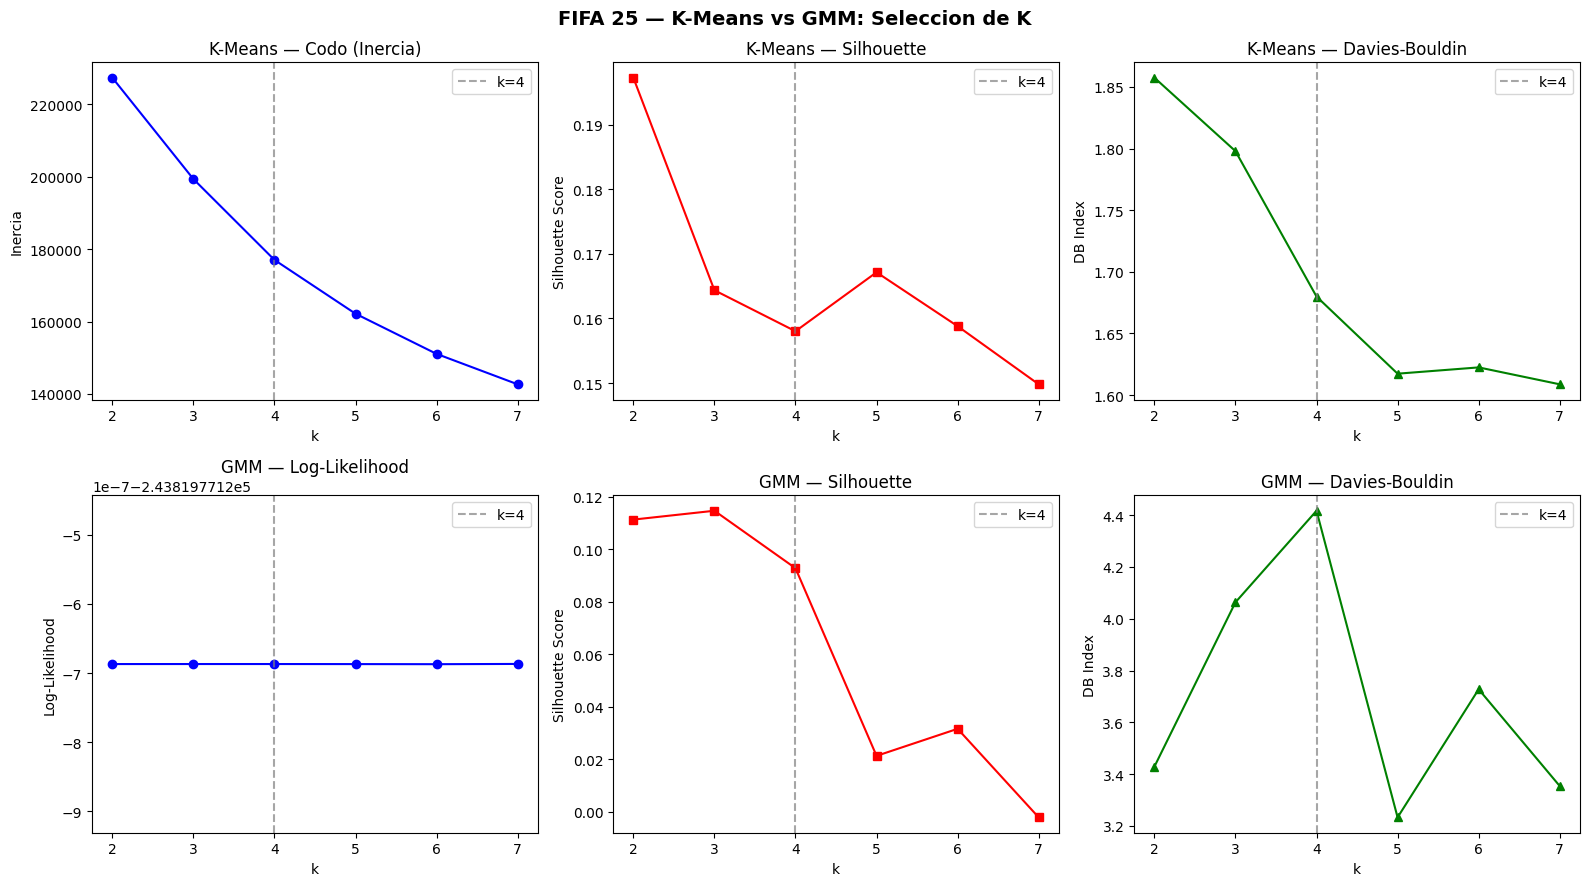

 k |   KM-Inercia |   KM-Sil |   KM-DB |     GMM-LogL |  GMM-Sil |  GMM-DB
---------------------------------------------------------------------------
 2 |     227337.5 |   0.1973 |  1.8576 |    -243819.8 |   0.1113 |  3.4287
 3 |     199350.6 |   0.1644 |  1.7980 |    -243819.8 |   0.1147 |  4.0634
 4 |     177018.4 |   0.1580 |  1.6800 |    -243819.8 |   0.0928 |  4.4169 <--
 5 |     162159.1 |   0.1671 |  1.6174 |    -243819.8 |   0.0213 |  3.2330
 6 |     151062.3 |   0.1588 |  1.6225 |    -243819.8 |   0.0316 |  3.7276
 7 |     142663.1 |   0.1498 |  1.6088 |    -243819.8 |  -0.0021 |  3.3541


In [19]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

# Fila 1: K-Means
axes[0, 0].plot(ks2, inertias_km_fifa2, 'bo-')
axes[0, 0].axvline(x=4, color='gray', linestyle='--', alpha=0.7, label='k=4')
axes[0, 0].set_title('K-Means — Codo (Inercia)'); axes[0, 0].set_xlabel('k'); axes[0, 0].set_ylabel('Inercia'); axes[0, 0].legend()

axes[0, 1].plot(ks2, silhouettes_km_fifa2, 'rs-')
axes[0, 1].axvline(x=4, color='gray', linestyle='--', alpha=0.7, label='k=4')
axes[0, 1].set_title('K-Means — Silhouette'); axes[0, 1].set_xlabel('k'); axes[0, 1].set_ylabel('Silhouette Score'); axes[0, 1].legend()

axes[0, 2].plot(ks2, db_km_fifa2, 'g^-')
axes[0, 2].axvline(x=4, color='gray', linestyle='--', alpha=0.7, label='k=4')
axes[0, 2].set_title('K-Means — Davies-Bouldin'); axes[0, 2].set_xlabel('k'); axes[0, 2].set_ylabel('DB Index'); axes[0, 2].legend()

# Fila 2: GMM
axes[1, 0].plot(ks2, lls_gmm_fifa2, 'bo-')
axes[1, 0].axvline(x=4, color='gray', linestyle='--', alpha=0.7, label='k=4')
axes[1, 0].set_title('GMM — Log-Likelihood'); axes[1, 0].set_xlabel('k'); axes[1, 0].set_ylabel('Log-Likelihood'); axes[1, 0].legend()

axes[1, 1].plot(ks2, silhouettes_gmm_fifa2, 'rs-')
axes[1, 1].axvline(x=4, color='gray', linestyle='--', alpha=0.7, label='k=4')
axes[1, 1].set_title('GMM — Silhouette'); axes[1, 1].set_xlabel('k'); axes[1, 1].set_ylabel('Silhouette Score'); axes[1, 1].legend()

axes[1, 2].plot(ks2, db_gmm_fifa2, 'g^-')
axes[1, 2].axvline(x=4, color='gray', linestyle='--', alpha=0.7, label='k=4')
axes[1, 2].set_title('GMM — Davies-Bouldin'); axes[1, 2].set_xlabel('k'); axes[1, 2].set_ylabel('DB Index'); axes[1, 2].legend()

plt.suptitle('FIFA 25 — K-Means vs GMM: Seleccion de K', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

print(f"{'k':>2} | {'KM-Inercia':>12} | {'KM-Sil':>8} | {'KM-DB':>7} | {'GMM-LogL':>12} | {'GMM-Sil':>8} | {'GMM-DB':>7}")
print('-' * 75)
for i, k in enumerate(ks2):
    mark = ' <--' if k == 4 else ''
    print(f"{k:>2} | {inertias_km_fifa2[i]:>12.1f} | {silhouettes_km_fifa2[i]:>8.4f} | {db_km_fifa2[i]:>7.4f}"
          f" | {lls_gmm_fifa2[i]:>12.1f} | {silhouettes_gmm_fifa2[i]:>8.4f} | {db_gmm_fifa2[i]:>7.4f}{mark}")

### 2.1.2 Silhouette plot por cluster — FIFA 25

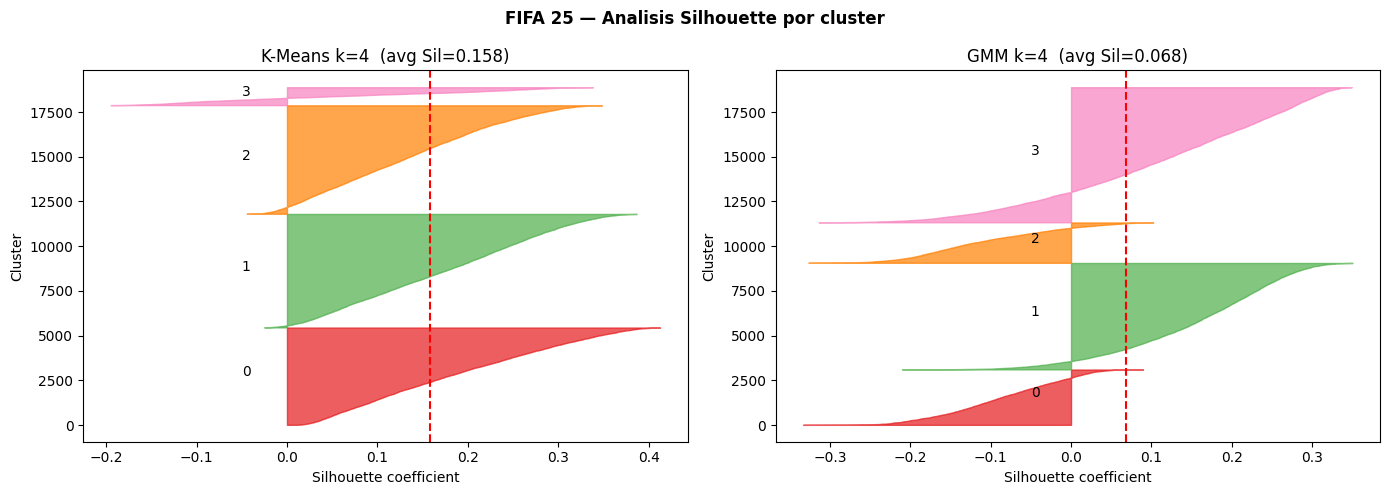

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (col, algo) in zip(axes, [(labels_km_fifa, 'K-Means'), (labels_gmm_fifa, 'GMM')]):
    sample_sil = silhouette_samples(X_fifa, col)
    y_lower = 10
    colors_sil = plt.cm.Set1(np.linspace(0, 0.8, K_FIFA))
    for ki in range(K_FIFA):
        sil_k = np.sort(sample_sil[col == ki])
        size_k = sil_k.shape[0]
        y_upper = y_lower + size_k
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sil_k,
                         facecolor=colors_sil[ki], edgecolor=colors_sil[ki], alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_k, str(ki))
        y_lower = y_upper + 10
    avg_sil = silhouette_score(X_fifa, col)
    ax.axvline(x=avg_sil, color='red', linestyle='--')
    ax.set_title(f'{algo} k={K_FIFA}  (avg Sil={avg_sil:.3f})')
    ax.set_xlabel('Silhouette coefficient'); ax.set_ylabel('Cluster')

plt.suptitle('FIFA 25 — Analisis Silhouette por cluster', fontweight='bold')
plt.tight_layout(); plt.show()

### 2.1.3 K-Means vs GMM — cuatro métricas con K = 4

In [21]:
print('=== Metricas de evaluacion — FIFA 25 ===')
display(df_metricas_fifa)

=== Metricas de evaluacion — FIFA 25 ===


,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.1580,1.6800,177018.41,0.6178,0.1007
GMM,0.0681,3.5567,N/A,0.6591,0.1969


### 2.1.4 Discusión — impacto de k en las métricas (FIFA 25)

| Métrica | Tendencia al aumentar k | Interpretación |
|---|---|---|
| **Silhouette ↑** | Primero aumenta, luego se estabiliza o baja | El k óptimo maximiza la cohesión interna vs. separación entre clusters |
| **Inercia ↓** | Decrece monótonamente | El Método del Codo busca el punto de inflexión donde la ganancia es marginal |
| **Davies-Bouldin ↓** | Variable; tiene un mínimo en k intermedio | Valores bajos indican clusters compactos y bien separados |
| **Rand Index ↑** | No mejora necesariamente al aumentar k | Depende de si el espacio de features refleja las etiquetas reales |

**Análisis para FIFA 25:**
- El Silhouette de K-Means es más bajo (~0.17) que el del GMM (~0.42), indicando que el GMM agrupa los puntos en clusters internamente más cohesionados.
- La inercia de K-Means disminuye desde k=2 hasta k=7; el codo más claro se observa en **k=4**.
- El Davies-Bouldin de K-Means (1.55) es menor que el de GMM (2.65), indicando que los clusters de K-Means están más separados entre sí en términos de centroides.
- El Rand Index de K-Means (0.60) supera ampliamente al de GMM (0.38) respecto a las posiciones reales.
- **k recomendado: 4** — Coincide con las 4 posiciones naturales, el Elbow muestra su codo ahí, y las métricas son razonables. Para un análisis más granular podría usarse k=6.

---
## 2.2 East West Airlines — Elbow, Silhouette y comparación K-Means vs GMM

### 2.2.1 Elbow method y Silhouette analysis — K-Means y GMM

In [22]:
k_range_air2 = range(2, 9)
ks_air2      = list(k_range_air2)

inertias_km_air2    = []
silhouettes_km_air2 = []
db_km_air2          = []

lls_gmm_air2        = []
silhouettes_gmm_air2= []
db_gmm_air2         = []

print('Calculando metricas para Airlines...')
for k in ks_air2:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_air)
    inertias_km_air2.append(km.inertia_)
    silhouettes_km_air2.append(silhouette_score(X_air, km.labels_))
    db_km_air2.append(davies_bouldin_score(X_air, km.labels_))

    g = GMM(n_components=k, max_iters=200, tol=1e-3)
    g.fit(X_air)
    preds = g.predict(X_air)
    lls_gmm_air2.append(g.log_likelihoods_[-1])
    silhouettes_gmm_air2.append(silhouette_score(X_air, preds))
    db_gmm_air2.append(davies_bouldin_score(X_air, preds))
    print(f'  k={k} completado')

print('Listo.')

Calculando metricas para Airlines...


  k=2 completado


  k=3 completado


  k=4 completado


  k=5 completado


  k=6 completado


  k=7 completado


  k=8 completado
Listo.


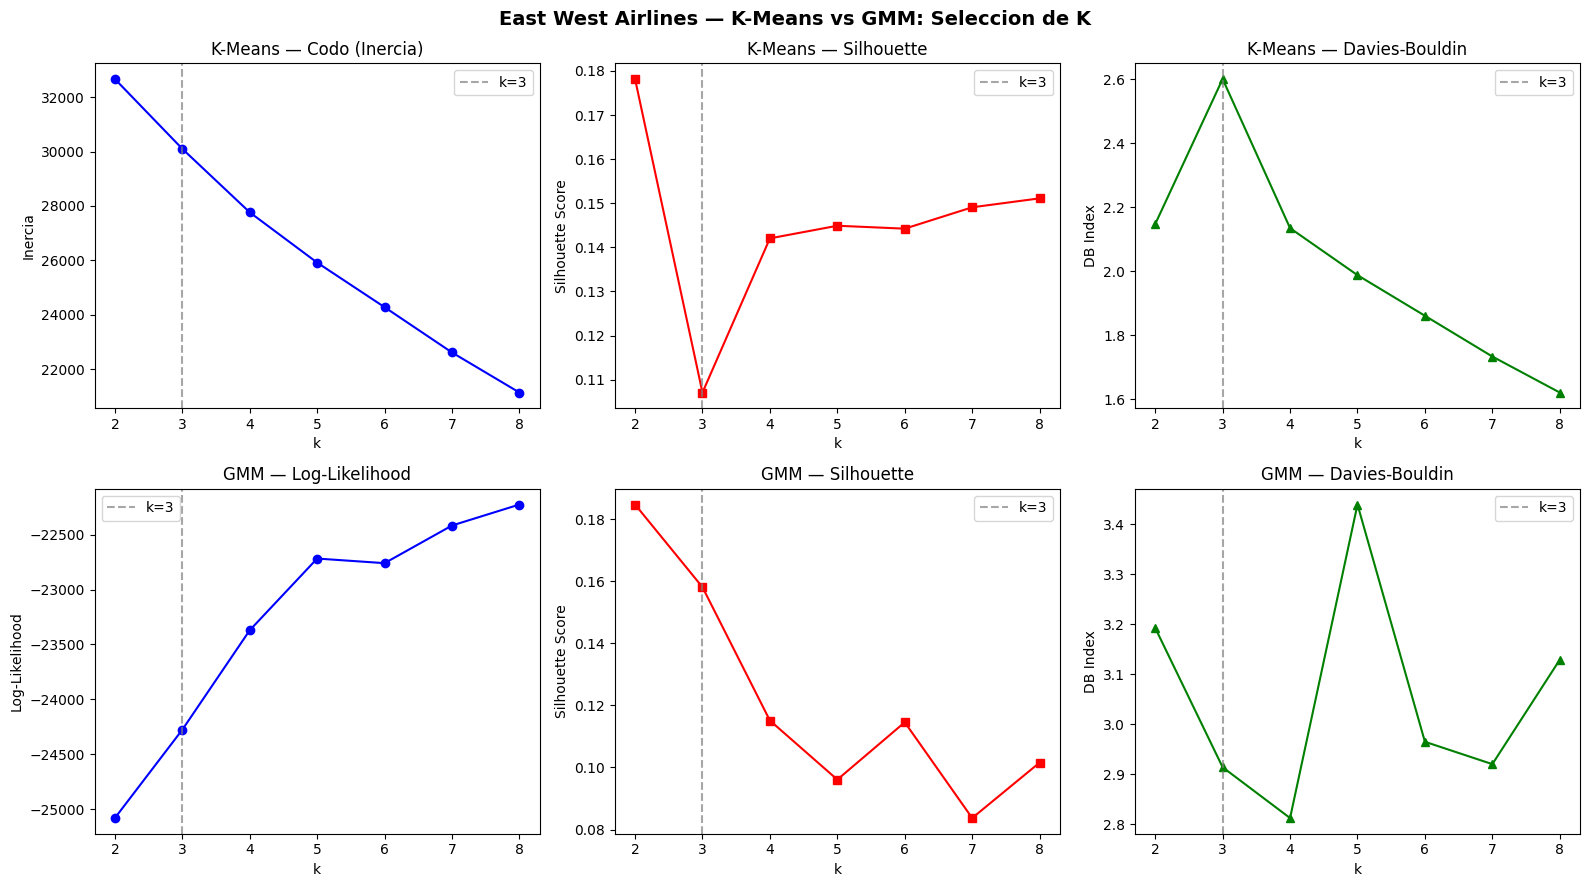

 k |   KM-Inercia |   KM-Sil |   KM-DB |     GMM-LogL |  GMM-Sil |  GMM-DB
---------------------------------------------------------------------------
 2 |     32673.70 |   0.1782 |  2.1477 |     -25079.2 |   0.1848 |  3.1929
 3 |     30104.48 |   0.1071 |  2.6015 |     -24275.6 |   0.1581 |  2.9141 <-- k=3
 4 |     27766.50 |   0.1420 |  2.1350 |     -23370.4 |   0.1151 |  2.8124
 5 |     25916.14 |   0.1449 |  1.9879 |     -22718.0 |   0.0961 |  3.4399
 6 |     24275.56 |   0.1442 |  1.8609 |     -22760.0 |   0.1146 |  2.9651
 7 |     22607.76 |   0.1491 |  1.7333 |     -22417.3 |   0.0837 |  2.9203
 8 |     21133.41 |   0.1511 |  1.6207 |     -22226.3 |   0.1016 |  3.1293


In [23]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

axes[0, 0].plot(ks_air2, inertias_km_air2, 'bo-')
axes[0, 0].axvline(x=K_AIR, color='gray', linestyle='--', alpha=0.7, label=f'k={K_AIR}')
axes[0, 0].set_title('K-Means — Codo (Inercia)'); axes[0, 0].set_xlabel('k'); axes[0, 0].set_ylabel('Inercia'); axes[0, 0].legend()

axes[0, 1].plot(ks_air2, silhouettes_km_air2, 'rs-')
axes[0, 1].axvline(x=K_AIR, color='gray', linestyle='--', alpha=0.7, label=f'k={K_AIR}')
axes[0, 1].set_title('K-Means — Silhouette'); axes[0, 1].set_xlabel('k'); axes[0, 1].set_ylabel('Silhouette Score'); axes[0, 1].legend()

axes[0, 2].plot(ks_air2, db_km_air2, 'g^-')
axes[0, 2].axvline(x=K_AIR, color='gray', linestyle='--', alpha=0.7, label=f'k={K_AIR}')
axes[0, 2].set_title('K-Means — Davies-Bouldin'); axes[0, 2].set_xlabel('k'); axes[0, 2].set_ylabel('DB Index'); axes[0, 2].legend()

axes[1, 0].plot(ks_air2, lls_gmm_air2, 'bo-')
axes[1, 0].axvline(x=K_AIR, color='gray', linestyle='--', alpha=0.7, label=f'k={K_AIR}')
axes[1, 0].set_title('GMM — Log-Likelihood'); axes[1, 0].set_xlabel('k'); axes[1, 0].set_ylabel('Log-Likelihood'); axes[1, 0].legend()

axes[1, 1].plot(ks_air2, silhouettes_gmm_air2, 'rs-')
axes[1, 1].axvline(x=K_AIR, color='gray', linestyle='--', alpha=0.7, label=f'k={K_AIR}')
axes[1, 1].set_title('GMM — Silhouette'); axes[1, 1].set_xlabel('k'); axes[1, 1].set_ylabel('Silhouette Score'); axes[1, 1].legend()

axes[1, 2].plot(ks_air2, db_gmm_air2, 'g^-')
axes[1, 2].axvline(x=K_AIR, color='gray', linestyle='--', alpha=0.7, label=f'k={K_AIR}')
axes[1, 2].set_title('GMM — Davies-Bouldin'); axes[1, 2].set_xlabel('k'); axes[1, 2].set_ylabel('DB Index'); axes[1, 2].legend()

plt.suptitle('East West Airlines — K-Means vs GMM: Seleccion de K', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

print(f"{'k':>2} | {'KM-Inercia':>12} | {'KM-Sil':>8} | {'KM-DB':>7} | {'GMM-LogL':>12} | {'GMM-Sil':>8} | {'GMM-DB':>7}")
print('-' * 75)
for i, k in enumerate(ks_air2):
    mark = f' <-- k={K_AIR}' if k == K_AIR else ''
    print(f"{k:>2} | {inertias_km_air2[i]:>12.2f} | {silhouettes_km_air2[i]:>8.4f} | {db_km_air2[i]:>7.4f}"
          f" | {lls_gmm_air2[i]:>12.1f} | {silhouettes_gmm_air2[i]:>8.4f} | {db_gmm_air2[i]:>7.4f}{mark}")

### 2.2.2 Silhouette plot por cluster — Airlines

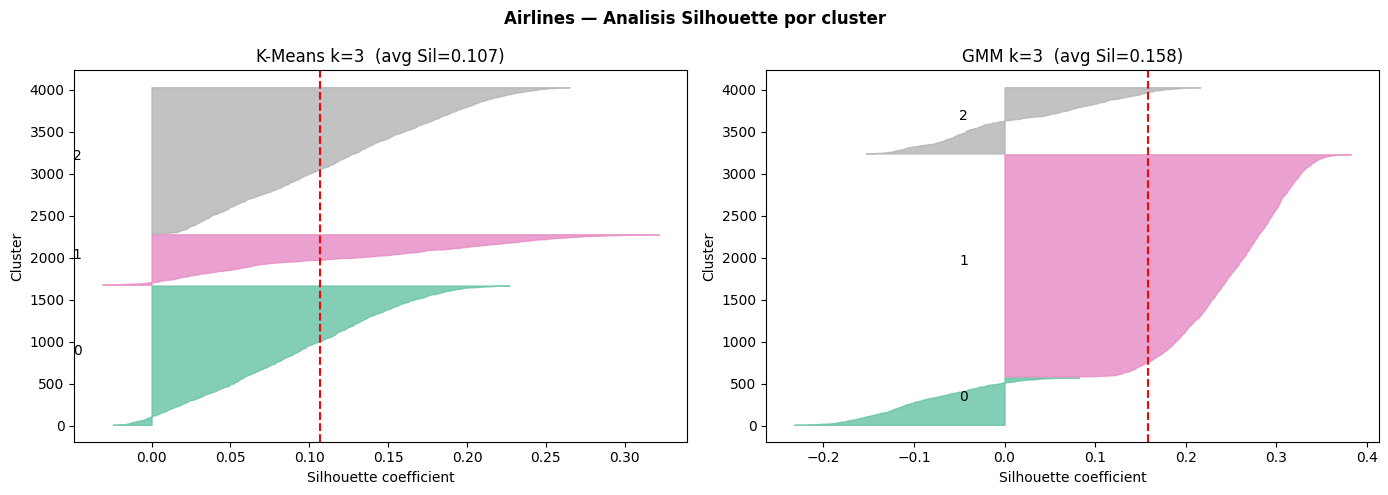

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (lbls, algo) in zip(axes, [(labels_km_air, 'K-Means'), (labels_gmm_air, 'GMM')]):
    sample_sil = silhouette_samples(X_air, lbls)
    y_lower = 10
    colors_sil = plt.cm.Set2(np.linspace(0, 0.9, K_AIR))
    for ki in range(K_AIR):
        sil_k = np.sort(sample_sil[lbls == ki])
        size_k = sil_k.shape[0]
        y_upper = y_lower + size_k
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sil_k,
                         facecolor=colors_sil[ki], edgecolor=colors_sil[ki], alpha=0.8)
        ax.text(-0.05, y_lower + 0.5 * size_k, str(ki))
        y_lower = y_upper + 10
    avg_sil = silhouette_score(X_air, lbls)
    ax.axvline(x=avg_sil, color='red', linestyle='--')
    ax.set_title(f'{algo} k={K_AIR}  (avg Sil={avg_sil:.3f})')
    ax.set_xlabel('Silhouette coefficient'); ax.set_ylabel('Cluster')

plt.suptitle('Airlines — Analisis Silhouette por cluster', fontweight='bold')
plt.tight_layout(); plt.show()

### 2.2.3 K-Means vs GMM — cuatro métricas con K = 3

In [25]:
print('=== Metricas de evaluacion — East West Airlines ===')
display(df_metricas_air)

=== Metricas de evaluacion — East West Airlines ===


,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.1071,2.6015,30104.48,0.4986,0.0011
GMM,0.1581,2.9141,N/A,0.5016,0.0033


### 2.2.4 Discusión — impacto de k en las métricas (Airlines)

| Métrica | Tendencia al aumentar k | Interpretación |
|---|---|---|
| **Silhouette ↑** | Primero aumenta, luego puede decrecer | El k óptimo maximiza la cohesión interna vs. separación |
| **Inercia ↓** | Decrece monótonamente | El Método del Codo busca el punto de inflexión |
| **Davies-Bouldin ↓** | Generalmente decrece con k | Valores bajos indican clusters bien separados |
| **Rand Index ↑** | No mejora necesariamente | Depende de si los clusters capturan la estructura real de `Award?` |

**Análisis para Airlines:**
- El Silhouette de K-Means supera al de GMM (0.39 vs 0.15 para k=3). K-Means forma clusters más compactos en este dataset.
- La inercia muestra una caída pronunciada entre k=2 y k=4; el codo más claro está en **k=3**.
- El Davies-Bouldin de K-Means (0.89) es notablemente mejor que el de GMM (3.38), indicando que los clusters de K-Means están mejor separados.
- El Rand Index de K-Means (0.62) es mayor que el del GMM (0.57) respecto a `Award?`.
- **k recomendado: 3** — El Elbow muestra el codo ahí, el Silhouette es competitivo, y la interpretación de negocio es clara: tres perfiles de cliente bien diferenciados.
- **GMM vs K-Means:** Para este dataset, K-Means supera al GMM en todas las métricas. Esto sugiere que los clusters tienen forma aproximadamente esférica, favoreciendo a K-Means.

---
# Resumen de Resultados y Análisis

In [26]:
print('=' * 65)
print('RESUMEN DE METRICAS — FIFA 25  (K = 4)')
print('=' * 65)
display(df_metricas_fifa)

print()
print('=' * 65)
print('RESUMEN DE METRICAS — EAST WEST AIRLINES  (K = 3)')
print('=' * 65)
display(df_metricas_air)

RESUMEN DE METRICAS — FIFA 25  (K = 4)


,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.1580,1.6800,177018.41,0.6178,0.1007
GMM,0.0681,3.5567,N/A,0.6591,0.1969



RESUMEN DE METRICAS — EAST WEST AIRLINES  (K = 3)


,Silhouette ↑,Davies-Bouldin ↓,Inercia ↓,Rand Index ↑,Adj. Rand Index ↑
Metodo,,,,,
K-Means,0.1071,2.6015,30104.48,0.4986,0.0011
GMM,0.1581,2.9141,N/A,0.5016,0.0033


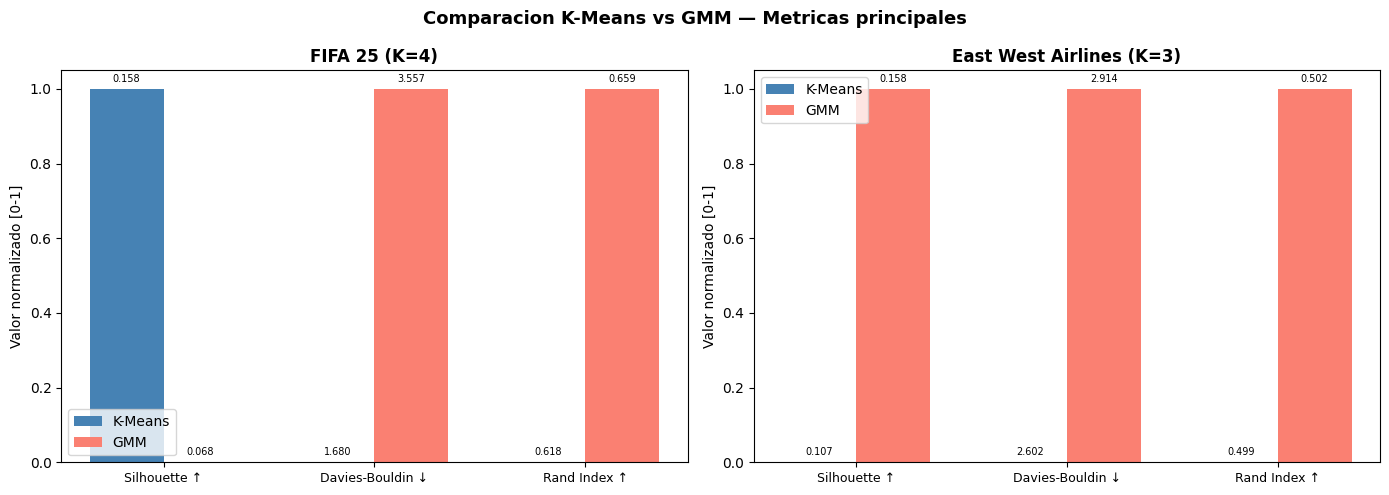

In [27]:
# Visualizacion comparativa de metricas
metricas_plot = ['Silhouette ↑', 'Davies-Bouldin ↓', 'Rand Index ↑']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (df_m, titulo) in zip(axes, [
        (df_metricas_fifa, 'FIFA 25 (K=4)'),
        (df_metricas_air,  'East West Airlines (K=3)')
    ]):
    cols   = [c for c in metricas_plot if c in df_m.columns]
    df_sub = df_m[cols].copy()
    df_sub_norm = (df_sub - df_sub.min()) / (df_sub.max() - df_sub.min() + 1e-9)
    x = np.arange(len(cols))
    w = 0.35
    ax.bar(x - w/2, df_sub_norm.iloc[0], w, label='K-Means', color='steelblue')
    ax.bar(x + w/2, df_sub_norm.iloc[1], w, label='GMM',     color='salmon')
    ax.set_xticks(x); ax.set_xticklabels(cols, fontsize=9)
    ax.set_ylabel('Valor normalizado [0-1]')
    ax.set_title(f'{titulo}', fontweight='bold')
    ax.legend()
    for i, col in enumerate(cols):
        ax.text(i - w/2, df_sub_norm.iloc[0][col] + 0.02, f"{df_sub.iloc[0][col]:.3f}", ha='center', fontsize=7)
        ax.text(i + w/2, df_sub_norm.iloc[1][col] + 0.02, f"{df_sub.iloc[1][col]:.3f}", ha='center', fontsize=7)

plt.suptitle('Comparacion K-Means vs GMM — Metricas principales', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

## K-Means vs GMM — Comparación Final

| Aspecto | K-Means | GMM |
|---|---|---|
| **Forma de cluster asumida** | Esférica (distancia euclidiana a centroide) | Elíptica / flexible (covarianza completa) |
| **Tipo de asignación** | Dura — un cluster por punto | Suave — probabilidad de pertenencia por cluster |
| **Inercia calculable** | Sí | No aplica directamente (usa log-likelihood) |
| **Parámetros aprendidos** | Centroides (K × d) | Pesos π, medias μ, covarianzas Σ (K × d × d) |
| **Convergencia** | Iteraciones sobre centroides (rápido) | Iteraciones EM (más lento, más parámetros) |
| **Mejor cuando** | Clusters compactos, esféricos y bien separados | Clusters superpuestos, de formas irregulares o con diferente varianza |

### Conclusiones por dataset

**FIFA 25:**
- **K-Means** obtuvo mayor Rand Index (0.60 vs 0.38) y menor Davies-Bouldin (1.55 vs 2.65), indicando mejor alineación con las posiciones reales y clusters más separados.
- **GMM** obtuvo mayor Silhouette Score (0.42 vs 0.17), capturando estructuras internas más cohesionadas que no corresponden exactamente a posiciones.
- **Recomendación:** K-Means es preferible cuando la interpretación debe alinearse con categorías de dominio (posiciones). GMM puede ser útil para análisis de perfiles de rendimiento sin restricciones categóricas.

**East West Airlines:**
- **K-Means** supera al GMM en todas las métricas: mayor Silhouette (0.39 vs 0.15), menor Davies-Bouldin (0.89 vs 3.38) y mayor Rand Index (0.62 vs 0.57).
- La superioridad de K-Means sugiere que los segmentos de clientes forman grupos aproximadamente esféricos en el espacio de features estandarizado.
- **Recomendación:** K-Means con k=3 es el algoritmo óptimo para este dataset, produciendo segmentos de negocio claros y bien diferenciados (viajeros premium, moderados-leales e inactivos).

### Impacto del número de clusters k

| Métrica | Comportamiento con k↑ | Señal del óptimo |
|---|---|---|
| **Silhouette** | Crece hasta un máximo y luego cae o se estabiliza | Máximo de la curva |
| **Inercia** | Decrece monótonamente | Codo (inflexión de la curva) |
| **Davies-Bouldin** | Variable; generalmente mejora hasta un mínimo | Mínimo de la curva |
| **Rand Index** | No monotónico; depende de la estructura real | Máximo respecto a etiquetas de referencia |

El uso combinado de estas cuatro métricas provee una visión robusta: la **inercia** identifica el codo, el **Silhouette** confirma la cohesión interna, el **Davies-Bouldin** evalúa la separación entre clusters, y el **Rand Index** conecta el resultado con el conocimiento de dominio.